In [1]:
# import os

# # home_dir = '/content/gdrive/My Drive/AChina' 
# # home_dir = '/hy-tmp'
# # os.chdir(home_dir)
# # pwd

# !pip install tqdm 
# !pip install fire

# from glob import glob
# from tqdm import tqdm

# import numpy as np
# import pandas as pd

# import os
# import warnings
# import sys

# import fire

# # warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# # os.chdir("../../..")

# !pip install scipy
# !pip install torch 
# !pip install pytorch_lightning==1.9.0 pytorch_forecasting

# import copy
# from pathlib import Path
# import warnings

# import time

# import numpy as np
# import pandas as pd
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# from pytorch_lightning.loggers import TensorBoardLogger
# import torch

# from typing import Any, Callable, Dict, List, Optional, Tuple, Union
# from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
# from pytorch_forecasting.data import GroupNormalizer
# from pytorch_forecasting.metrics import MAPE, SMAPE, PoissonLoss, QuantileLoss, RMSE, MAE
# from matplotlib import pyplot as plt
# from pytorch_lightning.utilities.model_summary import summarize
# from pytorch_forecasting import TemporalFusionTransformer
# from pytorch_lightning import Trainer
# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
# from matplotlib import pyplot as plt

# from multiprocessing import Pool, freeze_support

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
home_dir = '/hy-tmp'        
os.chdir(home_dir)

!pwd

# !ls

pl.seed_everything(1234, workers=True)

# from google.colab import drive
# drive.mount('/content/gdrive/')

# !ls

# home_dir = '/content/gdrive/My Drive/AChina'        
# os.chdir(home_dir)
# !pwd

if __name__ == "__main__":
    
    freeze_support()
    warnings.filterwarnings("ignore")
    
    fire.Fire(RunTask)

/hy-tmp


Global seed set to 1234


1234

In [3]:
import os

# home_dir = '/content/gdrive/My Drive/AChina' 
# home_dir = '/hy-tmp'
# os.chdir(home_dir)
# pwd

# pip install tqdm 

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import os
import warnings
import sys

import fire

# warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# os.chdir("../../..")

#pip install scipy
#pip install torch pytorch-lightning pytorch_forecasting

import copy
from pathlib import Path
import warnings

import time

import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAPE, SMAPE, PoissonLoss, QuantileLoss, RMSE, MAE, MASE
from matplotlib import pyplot as plt
from pytorch_lightning.utilities.model_summary import summarize
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from matplotlib import pyplot as plt

from pytorch_forecasting.metrics import MultiHorizonMetric  #, CompositeMetric

from multiprocessing import Pool, freeze_support

from multiprocessing import Pool, freeze_support

from pytorch_lightning.callbacks import LearningRateFinder

from pytorch_lightning.callbacks import GradientAccumulationScheduler

from utils import FineTuneLearningRateFinder_0, FineTuneLearningRateFinder_1, FineTuneLearningRateFinder_2
from utils import FineTuneLearningRateFinder_CyclicLR, FineTuneLearningRateFinder_LinearLR
from utils import ReloadDataLoader, ReloadDataSet
from utils import DataGenerator, DataGenerator_split
    
from pytorch_forecasting.metrics import MultiHorizonMetric

# from LRCustom import custom_lr_find

class Myloss(MultiHorizonMetric):
    """
    sqrtRMSE + MAE

    Defined as ``sqrt{(y_pred - target)**2} + (y_pred - target).abs()``
    """
        
    def loss(self, y_pred, target):
        loss = ( torch.pow(self.to_prediction(y_pred) - target, 2) / \
                torch.pow(self.to_prediction(y_pred) - target.mean(), 2) )
        return loss
    
# MOD_BINS = 512
# FAM_BINS = 256

MOD_BINS = 128
FAM_BINS = 64

class ModelBase:
    
    def __init__(self, 
                 home_dir = '/hy-tmp',
                 datasetfile = f'data/ALIM{MOD_BINS}F{FAM_BINS}DATASET_rice.csv',
                 # datasetfile = 'corn_china_pandas_onebands.csv',
                 predicted_years = "2004 2010 2017",
                 batch_size = 16, 
                 # encoder_length = 20,
                 save_checkpoint = False,
                 save_checkpoint_model = 'best-model',
                 learning_rate = 0.01,
                 max_epochs = 200,
                 lr_milestones_list = [20, 50, 600, 800,],
                 loss_func_metric = 'RMSE',
                 seed = 123456,
                 crop_name = 'rice',
                 exp_name = '',            
                ):
    
        self.home_dir = home_dir
        os.chdir(self.home_dir)
        
        pl.seed_everything(seed, workers=True)
        
        print(exp_name, crop_name)
        
        if len(exp_name) == 0:
            print("exp_name is not definite")
            sys.exit(0)
        if len(crop_name) == 0:
            print("crop_name is not definite")
            sys.exit(0)
            
        self.loss_func = RMSE()
        
        if loss_func_metric == 'RMSE':
            self.loss_func = RMSE()
        elif loss_func_metric == 'MAE':
            self.loss_func = MAE()
        elif loss_func_metric == 'MASE':
            self.loss_func = MASE()
        elif loss_func_metric == 'QuantileLoss':
            self.loss_func = QuantileLoss()
        elif loss_func_metric == 'Myloss':
            self.loss_func = SMAPE() + MAE()
            
        self.exp_name = exp_name
        self.crop_name = crop_name
        self.scrop = crop_name
        self.batch_size = batch_size
        self.predicted_years = predicted_years.split()
        
        self.learning_rate = learning_rate
        
        self.datasetfile = datasetfile
        
        self.lr_milestones_list = lr_milestones_list
        
        self.max_epochs = max_epochs
        
        # MOD_BINS = 512
        # FAM_BINS = 256
        
        print('predicted_years:', self.predicted_years, 'max_epochs:', max_epochs, 'batch_size:', batch_size, \
              'learning_rate', self.learning_rate, \
              'loss_func_metric:', loss_func_metric, 'seed:', seed, 'lr_milestones_list:', lr_milestones_list)
        
        # sys.exit(0)
        # fn
        
        print(f'loading {self.datasetfile}', time.asctime( time.localtime(time.time()) ) )
        alidata = pd.read_csv(self.datasetfile)
        # alidata = pd.read_csv(f'data/ALIM{MOD_BINS}F{FAM_BINS}DATASET_{scrop}.csv')
        print(f'{self.datasetfile} loaded', time.asctime( time.localtime(time.time()) ) )
        
        # display(alidata)
        
        # cealr unnamed fields from dataset
        alidata = alidata.loc[:, ~alidata.columns.str.contains('^Unnamed')]

        alidata['county']   = alidata['county'].astype(str)
        alidata['year']     = alidata['year'].astype(str)
        alidata['time_idx'] = alidata['time_idx'].astype(int)
        
        alidata['actuals'] = alidata[f'{self.scrop}_yield']

        print(type(alidata['county']), type(alidata['year']), type(alidata['time_idx'].max()))

        yield_list = [f'{self.scrop}_sownarea', f'avg_{self.scrop}_sownarea', f'med_{self.scrop}_sownarea', \
                      f'{self.scrop}_yieldval', f'avg_{self.scrop}_yieldval', f'med_{self.scrop}_yieldval', \
                      f'{self.scrop}_yield', f'avg_{self.scrop}_yield', f'med_{self.scrop}_yield']

        cols_to_move = yield_list
        alidata = alidata[ [ col for col in alidata.columns if col not in cols_to_move ] + cols_to_move ]

        # df_not_str = alidata.select_dtypes(include=float).astype("float32")
        # df_str = alidata.select_dtypes(exclude=float)

        # alidata = df_not_str.join(df_str)

        # DON'T DELETE, cut dataset by month
        alidata = alidata[ alidata['month'] < 10 ]
        # alidata['month'] = alidata['month'].astype(str)
        
        alidata['gstage'] = 'yield'
        
#         bad_year = '2008'
        
#         alidata = alidata[ alidata['year'] != bad_year]

        # display(alidata)        
        
        infer_mask = alidata['year'].isin(['2019', '2020', '2021', '2022'])

        data_infer = alidata[infer_mask]

        data_infer['rice_sownarea'] = 0.0    #np.nan
        data_infer['rice_yieldval'] = 0.0    #np.nan
        data_infer['rice_yield']    = 0.0    #np.nan

        years = [str(x) for x in range(2003, 2019)]

        self.val_years = self.predicted_years 
        # Remove predicted year from train dataset  
        for iyear in self.val_years:
            years.remove(iyear)      
        self.years = years
        
        print('Years to train:', self.years)
        print('Years to valid:', self.val_years)
        
        # tt = [x for x in self.val_years]
        # print('tt', tt)
        
        self.name_for_files = f'A0cr[{self.scrop}]-yr[{"_".join(self.val_years)}]-en[{self.exp_name}]-bs[{self.batch_size}]-lr[{self.learning_rate}]'
        
        print('self.name_for_files:', self.name_for_files)
        
        # fn
        

        train_mask = alidata['year'].isin(self.years)
        self.data = alidata[train_mask]

        val_mask = alidata['year'].isin(self.val_years)
        self.data_val = alidata[val_mask]
        
        self.data = self.data[ self.data['year'] != '2008' ]
        self.years = self.data['year'].unique()
        
        print('--------check 2008----------------------')
        print('Years to train:', self.years)
        print('Years to valid:', self.val_years)
        print('Years to valid:', self.data_val['year'].unique())
        print('------------------------------')

        # display(self.data_infer)

        # display(self.data)

        # display(self.data_val)

        self.data_inference = pd.concat([self.data_val, data_infer], axis=0)

        # display(self.data_inference)

        # print(len(data['county'].unique()), len(data['year'].unique()))
        
        # max_prediction_length = 4
        # max_encoder_length = 20
        # training_cutoff = data["time_idx"].max() - max_prediction_length
        # min_prediction_idx = 20 #int( training_cutoff )
        ###################################################################################################
        # self.max_encoder_length = 30  # int(training_cutoff - max_prediction_length)
        # self.max_prediction_length = int(self.data["time_idx"].max() - self.max_encoder_length + 1)
        ###################################################################################################
#         self.max_prediction_length = 15  # int(training_cutoff - max_prediction_length)
#         self.max_encoder_length = int(self.data["time_idx"].max() - self.max_prediction_length + 1)

#         print('max_prediction_length:', self.max_prediction_length, self.max_encoder_length, type(self.data["time_idx"][0]), type(self.max_encoder_length) )
        # fn

        # print(training_cutoff, data['time_idx'][0])

        for county in self.data['county'].unique():
            for year in self.data['year'].unique():
                avg_yield = self.data['avg_rice_yield'].loc[(self.data['county'] == county) & (self.data['year'] == year)].mean()
                med_yield = self.data['med_rice_yield'].loc[(self.data['county'] == county) & (self.data['year'] == year)].mean()
                rice_yield = self.data['rice_yield'].loc[(self.data['county'] == county) & (self.data['year'] == year)].mean()
                
                self.data['rice_yield'].loc[(self.data['county'] == county) & (self.data['year'] == year) & \
                                            (self.data['month'] < 6) ] = avg_yield
                self.data['gstage'].loc[(self.data['county'] == county) & (self.data['year'] == year) & \
                                        (self.data['month'] < 6) ] = "no"       
                
                self.data['rice_yield'].loc[( (self.data['county'] == county) & (self.data['year'] == year) ) & \
                                            ( (self.data['month'] == 6) | (self.data['month'] == 7) ) ] = \
                                       [avg_yield + ((rice_yield - avg_yield) / 8.0) * i for i in range(1,9)]
                self.data['gstage'].loc[( (self.data['county'] == county) & (self.data['year'] == year) ) & \
                                        ( (self.data['month'] == 6) | (self.data['month'] == 7) ) ] = \
                                        "growth"
                
                

        for county in self.data_val['county'].unique():
            for year in self.data_val['year'].unique():
                avg_yield = self.data_val['avg_rice_yield'].loc[(self.data_val['county'] == county) & (self.data_val['year'] == year)].mean()
                med_yield = self.data_val['med_rice_yield'].loc[(self.data_val['county'] == county) & (self.data_val['year'] == year)].mean()
                rice_yield = self.data_val['rice_yield'].loc[(self.data_val['county'] == county) & (self.data_val['year'] == year)].mean()
                
                self.data_val['rice_yield'].loc[(self.data_val['county'] == county) & (self.data_val['year'] == year) & \
                                            (self.data_val['month'] < 6) ] = avg_yield
                self.data_val['gstage'].loc[(self.data_val['county'] == county) & (self.data_val['year'] == year) & \
                                        (self.data_val['month'] < 6) ] = "no"       
                
                self.data_val['rice_yield'].loc[( (self.data_val['county'] == county) & (self.data_val['year'] == year) ) & \
                                            ( (self.data_val['month'] == 6) | (self.data_val['month'] == 7) ) ] = \
                                       [avg_yield + ((rice_yield - avg_yield) / 8.0) * i for i in range(1,9)]
                self.data_val['gstage'].loc[( (self.data_val['county'] == county) & (self.data_val['year'] == year) ) & \
                                        ( (self.data_val['month'] == 6) | (self.data_val['month'] == 7) ) ] = \
                                        "growth"

        for county in self.data_inference['county'].unique():
            for year in self.data_inference['year'].unique():
                avg_yield = self.data_inference['avg_rice_yield'].loc[(self.data_inference['county'] == county) & \
                                                                      (self.data_inference['year'] == year)].mean()
                med_yield = self.data_inference['med_rice_yield'].loc[(self.data_inference['county'] == county) & \
                                                                      (self.data_inference['year'] == year)].mean()
                
                self.data_inference['rice_yield'].loc[(self.data_inference['county'] == county) \
                                                 & (self.data_inference['year'] == year) & \
                                                 (self.data_inference['month'] < 6) ] \
                                                 = avg_yield# (avg_yield + med_yield) / 2.0
                self.data_inference['gstage'].loc[(self.data_inference['county'] == county) \
                                                 & (self.data_inference['year'] == year) & \
                                                 (self.data_inference['month'] < 6) ] \
                                                 = "no"

                self.data_inference['rice_yield'].loc[(self.data_inference['county'] == county) \
                                                 & (self.data_inference['year'] == year) & \
                                                 ( (self.data_inference['month'] == 6) | (self.data_inference['month'] == 7) ) ] = \
                                                 [avg_yield + ((rice_yield - avg_yield) / 8.0) * i for i in range(1,9)]
                self.data_inference['gstage'].loc[(self.data_inference['county'] == county) \
                                                 & (self.data_inference['year'] == year) & \
                                                 ( (self.data_inference['month'] == 6) | (self.data_inference['month'] == 7) ) ] = \
                                                 "growth"        
                    
                    
        self.data['month'] = self.data['month'].astype(str)
        self.data_val['month'] = self.data_val['month'].astype(str)
        self.data_inference['month'] = self.data_inference['month'].astype(str)
        
        
        
        # self.data['actuals'] = self.data["rice_yieldval"] / self.data["rice_sownarea"]
        # self.data_val['actuals'] = self.data_val["rice_yieldval"] / self.data_val["rice_sownarea"]
        # self.data_inference['actuals'] = self.data_inference["rice_yieldval"] / self.data_inference["rice_sownarea"]
        
        ############### INIT data_train with all years in timeseries ######################################~
        self.data_train, _ = DataGenerator_split(TRAIN_DATA=self.data, VALID_DATA=self.data_val, YEARS_MAX_LENGTH=2, NSAMPLES=4)

        smpl = '1'
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
        # fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
        
        print(type(self.data_train['time_idx']))
        
        df = self.data_train[ (self.data_train['county'] == '0') & (self.data_train['sample'] == smpl) ]
        
        print(df['time_idx'].to_numpy())
        print(self.data_train['sample'].unique())
        print(self.data_train['county'].unique())
        print(df['year'].unique())
        
        print(df['time_idx'].to_numpy())
        # print(dfali['time_idx'].to_numpy())
        
        ax.plot(df['time_idx'].to_numpy(), df['rice_yield'].to_numpy(), 'o')
        # Create the second y-axis
        ax2 = ax.twiny().twinx()
        ax2.plot(df['time_idx'].to_numpy(), df['gstage'], 'x', color='green')

        ######### ENCODER-DECODER ############################################################################
        
        
        dfsmpl = self.data_train[ (self.data_train['sample'] == smpl) & (self.data_train['county'] == '0') ]
        print('self.val_years[0]:',self.val_years, dfsmpl['year'].unique())
        
        dflast = self.data_train[ (self.data_train['sample'] == smpl) & (self.data_train['county'] == '0')  & ( (self.data_train['year'] == self.val_years[0]) | (self.data_train['year'] == self.val_years[1]) | (self.data_train['year'] == self.val_years[2]) )]
        
        dfe = self.data_train[ (self.data_train['gstage'] == 'no') & (self.data_train['sample'] == smpl) & (self.data_train['county'] == '0') & ( (self.data_train['year'] == self.val_years[0]) | (self.data_train['year'] == self.val_years[1]) | (self.data_train['year'] == self.val_years[2]) )] 
        
        dfp = self.data_train[ ( (self.data_train['gstage'] == 'growth') | (self.data_train['gstage'] == 'yield') ) & (self.data_train['sample'] == smpl) & (self.data_train['county'] == '0')  & ( (self.data_train['year'] == self.val_years[0]) | (self.data_train['year'] == self.val_years[1]) | (self.data_train['year'] == self.val_years[2]) )]
        
        self.max_prediction_length = dfp.shape[0]
        self.max_encoder_length = dfe.shape[0]
        
        ######## PLOT & CHECK DATASET ############################################################
        
        ax.plot(dfe['time_idx'].to_numpy(), dfe['rice_yield'].to_numpy(), '.', color='yellow')
        ax.plot(dfp['time_idx'].to_numpy(), dfp['rice_yield'].to_numpy(), '.', color='red')
        
        print(self.max_encoder_length, self.max_prediction_length)   
        
        last_year = dfe['year'].unique()
        print('last_year:', last_year)
        dfali = alidata[ (alidata['county'] == '0') & (alidata['year'] == last_year[0]) ]
        print(len(dfali['time_idx'].to_numpy()), dfali['time_idx'].to_numpy())
        print(len(dflast['time_idx'].to_numpy()), dflast['time_idx'].to_numpy())
        dfali['time_idx'] = dflast['time_idx'].values
        print(dfali['time_idx'].to_numpy())
        ax.plot(dfali['time_idx'].to_numpy(), dfali['rice_yield'].to_numpy(), '-.')
        
        plt.show()
        plt.savefig('A0', bbox_inches='tight')           
        
        # fn
        
        # self.data_train = self.data
        
        # get the memory usage in bytes
        memory_bytes = self.data_train.memory_usage().sum()

        # convert to megabytes
        memory_mb = memory_bytes / (1024 ** 2)

        print(f"Dataframe size: {memory_mb:.2f} Mb")
        
        print('DataGenerator done...')
                
            
            # for ii in random_years:
            #     data_gen = pd.concat([self.data_val, data[]], axis=0)
                
            

        # avg_med = ["avg_rice_yield", "med_rice_yield", "avg_rice_sownarea", "med_rice_sownarea",\
        #                  "avg_rice_yieldval", "med_rice_yieldval"]
        
        # avg_med = ["avg_rice_yield", "rice_sownarea"]
        
        avg_med = ["avg_rice_yield"]
        
        # avg_med = []

        _static_reals = avg_med
        
        print("avg_med:", avg_med)
        
        time.sleep(15)      

        # display( data[ [ col for col in _time_varying_known_reals ] ] )

        # fn

        ################ MODIS cloumns name################################
        mod_names = [f'b{iband}b{bins}' for iband in range(9) for bins in range(MOD_BINS)]

        famine_list = ['Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg', 'Psurf_f_tavg', 'Qair_f_tavg', 'Qg_tavg',\
                       'Qh_tavg', 'Qle_tavg', 'Qs_tavg', 'Qsb_tavg', 'RadT_tavg', 'Rainf_f_tavg', \
                       'SnowCover_inst', 'SnowDepth_inst', 'Snowf_tavg', \
                       'SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', \
                       'SoilTemp00_10cm_tavg', 'SoilTemp10_40cm_tavg', 'SoilTemp40_100cm_tavg', \
                       'SWdown_f_tavg', 'SWE_inst', 'Swnet_tavg', 'Tair_f_tavg', 'Wind_f_tavg']

        nbins = ['_' + str(x) for x in range(0, FAM_BINS - 1)]

        famine_names = [famine + bb for famine in famine_list for bb in nbins]
        
        self._time_varying_known_reals = []
        self._time_varying_known_reals.extend(avg_med)
        self._time_varying_known_reals.extend(mod_names) 

        self._time_varying_unknown_reals = []
        self._time_varying_unknown_reals.extend(avg_med)
        self._time_varying_unknown_reals.extend(mod_names)
        # self._time_varying_unknown_reals.extend(famine_names)

        print( self.data.sort_values("time_idx").groupby(["county", "year"]).time_idx.diff().dropna() == 1 )

        print(f'training mx_epochs, TimeSeriesDataSet:', max_epochs, time.asctime( time.localtime(time.time()) ) )
        
        print('D1: known-unknown go --------------------------')
        print('D2: --------------------------')
        
        # fn

        # training_cutoff = data["time_idx"].max() - max_prediction_length
        
        self.training = TimeSeriesDataSet(
            self.data_train[lambda x: x.time_idx <= x.time_idx.max() - self.max_prediction_length],
            # self.data_train,
            time_idx="time_idx",
            target="rice_yield",
            group_ids=["county", "sample"],
            # group_ids=["county", "year"],
            min_encoder_length=self.max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length = self.max_encoder_length,
            min_prediction_length = 1,                     #max_prediction_length // 2,
            max_prediction_length = self.max_prediction_length,
            # min_prediction_idx = min_prediction_idx,
            # static_categoricals = ["county", "year"],
            # static_reals = _static_reals,
            time_varying_known_categoricals=["month"],
            # variable_groups={"years": years},  # group of categorical variables can be treated as one variable
            time_varying_known_reals = self._time_varying_known_reals,
            # time_varying_unknown_categoricals=[],
            time_varying_unknown_reals = self._time_varying_unknown_reals,
            target_normalizer=GroupNormalizer(
                groups=["county"], transformation="relu"
            ),  # use softplus and normalize by group
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

        print( time.asctime( time.localtime(time.time()) ) )

        self.testing = TimeSeriesDataSet(
            self.data_val,
            time_idx="time_idx",
            target="rice_yield",
            # group_ids=["county", "sample"],
            group_ids=["county", "year"],
            min_encoder_length=self.max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length = self.max_encoder_length,
            min_prediction_length = 1 , # max_prediction_length // 2,
            max_prediction_length = self.max_prediction_length,
            # min_prediction_idx = min_prediction_idx,
            # static_categoricals = ["county", "year"],
            # static_reals = _static_reals,
            time_varying_known_categoricals=["month"],
            # variable_groups={"years": years},  # group of categorical variables can be treated as one variable
            time_varying_known_reals = self._time_varying_known_reals,
            # time_varying_unknown_categoricals=[],
            time_varying_unknown_reals = self._time_varying_unknown_reals,
            target_normalizer=GroupNormalizer(
                groups=["county"], transformation="relu"
            ),  # use softplus and normalize by group
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

        # create validation set (predict=True) which means to predict the last max_prediction_length points in time
        # for each series
        self.validation = TimeSeriesDataSet.from_dataset(self.training, self.data_train, predict=True, stop_randomization=True)

        print(f'training & validation TimeSeriesDataSet loaded', time.asctime( time.localtime(time.time()) ) )
        
        # create dataloaders for model
        # batch_size = 16  # set this between 32 to 128
        self.train_dataloader = self.training.to_dataloader(train=True, batch_size=self.batch_size, num_workers=8)
        self.val_dataloader = self.validation.to_dataloader(train=False, batch_size=self.batch_size, num_workers=8)
        
        self.test_dataloader = self.testing.to_dataloader(train=False, batch_size=self.batch_size, num_workers=8)
        
        print( time.asctime( time.localtime(time.time()) ) )
        # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
        # for x, (y, weight) in iter(val_dataloader):
        #     print(type(y), y.size())

        actuals = torch.cat([y for x, (y, weight) in iter(self.val_dataloader)])
        baseline_predictions = Baseline().predict(self.val_dataloader)
        # print( 'Baseline:',type(actuals), actuals.size(), baseline_predictions.size(), actuals[0,:], baseline_predictions[0,:] )
        # print( torch.where(torch.isnan(actuals)), torch.where(torch.isnan(baseline_predictions)) )
        print( 'Baseline:', (actuals - baseline_predictions).abs().mean().item() )
        print( 'Baseline:', time.asctime( time.localtime(time.time()) ) )
    
        
        # dir = '/hy-tmp/chck/ali'
        # home_dir = '/content/gdrive/My Drive/AChina' 
        # _dir = os.path.join(home_dir, 'data')
        
        _checkpoint_callback = ModelCheckpoint(dirpath = os.path.join(home_dir, self.name_for_files), every_n_epochs = 50)

        _dir = '/tf_logs'
        # dir = os.path.join(home_dir, 'data')
        _logger = TensorBoardLogger(_dir, name = self.name_for_files, comment = self.name_for_files)

        _lr_monitor = LearningRateMonitor(logging_interval = 'epoch')

        _lr_finder  = FineTuneLearningRateFinder_CyclicLR(base_lr=0.0001, max_lr=0.01, step_size_up=60, step_size_down=60) 
        
        _GradAccumulator = GradientAccumulationScheduler(scheduling={0: 4, 60: 4, 150: 4})

        _SWA = StochasticWeightAveraging(swa_lrs=1e-2, swa_epoch_start=50, device='gpu')
        
        _reload_dataloader = ReloadDataLoader(self.training, self.batch_size)
        
        _reload_dataset = ReloadDataSet(self.data, self.training, self.batch_size)

        self.trainer = Trainer(accelerator='gpu', 
                               logger=_logger, 
                               log_every_n_steps=1, 
                               max_epochs=self.max_epochs,
                               # devices = "0",          
                               # fast_dev_run=True, 
                               # precision=16,
                               gradient_clip_val=0.2,
                               # reload_dataloaders_every_epoch=True,
                               callbacks=[_lr_finder, _checkpoint_callback, _lr_monitor, _reload_dataset])
        

        # learning_rate = 0.01

        self.tft = TemporalFusionTransformer.from_dataset(
            self.training,
            learning_rate=self.learning_rate,
            # # lstm_layers=2,
            # hidden_size=60,
            # hidden_continuous_size=30,
            # attention_head_size=4,
            dropout=0.3,          
            # output_size=7,  # 7 quantiles by default      
            loss=self.loss_func,
            # loss=QuantileLoss(),
            # optimizer = 'adam',
            optimizer = 'sgd',
            # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
            # reduce_on_plateau_patience=4,
            )

        ####################################################################
        
        self.best_tft = self.tft
        self.checkpoint = self.name_for_files
        
    def init_lr_finder(self, min_lr=1e-6):
        # Run learning rate finder
        lr_finder = self.trainer.tuner.lr_find(
            self.tft,
            train_dataloaders=self.train_dataloader,
            val_dataloaders=self.val_dataloader,
            max_lr=2.0,
            min_lr=min_lr,
            # mode='linear'
        )

        # Results can be found in
        lr_finder.results

        # Plot with
        fig = lr_finder.plot(suggest=True)
        fig.show()

        # Pick point based on plot, or get suggestion
        new_lr = lr_finder.suggestion()

        # update hparams of the model
        self.tft.hparams.lr = new_lr
        self.tft.hparams.learning_rate = new_lr

        print('new_lr:', self.tft.hparams.lr)

        print(f"suggested learning rate: {lr_finder.suggestion()}")
        fig = lr_finder.plot(show=True, suggest=True)
        # fig.show()

        fig.tight_layout()
        fig.savefig(f'Dlr_find_[{self.predicted_years}]_[{self.batch_size}].png', dpi=300, format='png')
        
    def custom_finder(self, min_lr=1e-3):
        # Run learning rate finder
        self.trainer.tuner.lr_find = custom_lr_find
        # trainer.tuner.lr_find = custom_lr_find
        lr_finder = self.trainer.tuner.lr_find(
            self.tft,
            train_dataloaders=self.train_dataloader,
            val_dataloaders=self.val_dataloader,
            max_lr=1.0,
            min_lr=min_lr,
            mode='linear'
        )

        # Results can be found in
        print('lr_finder.results:', lr_finder.results)

        # # Plot with
        # fig = lr_finder.plot(suggest=True)
        # fig.show()

        # Pick point based on plot, or get suggestion
        new_lr = lr_finder.suggestion()

        # update hparams of the model
        self.tft.hparams.lr = new_lr
        self.tft.hparams.learning_rate = new_lr

        print('new_lr:', self.tft.hparams.lr)

        print(f"suggested learning rate: {lr_finder.suggestion()}")
        fig = lr_finder.plot(show=True, suggest=True)
        fig.show()

        fig.tight_layout()
        fig.savefig(f'Dcustom_find_[{self.predicted_years}]_[{self.batch_size}].png', dpi=300, format='png')
        
    def find_init_lr():
        # find optimal learning rate
        res = trainer.tuner.lr_find(
            self.tft,
            train_dataloaders=self.train_dataloader,
            val_dataloaders=self.val_dataloader,
            max_lr=1.0,
            min_lr=1e-5,
        )

        print(f"suggested learning rate: {res.suggestion()}")
        fig = res.plot(show=True, suggest=True)
        fig.show()
        
    def train(self,):
        print( time.asctime( time.localtime(time.time()) ) )
        self.trainer.fit(
            self.tft,
            train_dataloaders = self.train_dataloader,
            val_dataloaders   = self.val_dataloader,
        )
        print('fit:', time.asctime( time.localtime(time.time()) ) )
        
        # load the best model according to the validation loss
        # (given that we use early stopping, this is not necessarily the last epoch)
        # os.chdir(os.path.join(home_dir, 'data'))
        #   best_model_path = trainer.checkpoint_callback.best_model_path
        # print(type(best_model_path))
        # best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

        print(f'weights saving to checkpoint: {self.checkpoint} in:', time.asctime( time.localtime(time.time()) ) )
        # checkpoint = f"{self.crop}-{self.val_year}-{self.exp_name}.ckpt"
        self.trainer.save_checkpoint(f'{self.checkpoint}.ckpt')
        print('weights loading', time.asctime( time.localtime(time.time()) ) )
        self.best_tft = self.tft  # TemporalFusionTransformer.load_from_checkpoint(checkpoint)
        print('weights loaded', time.asctime( time.localtime(time.time()) ) )
        
        # print('Train(): learning_rate', self.model.hparams.learning_rate)
        # self.trainer = self.trainer.fit(self.model, train_dataloaders=self.train_dataloader, val_dataloaders=self.valid_dataloader)
        # self.best_tft = self.model
        # if self.save_checkpoint_model == 'best-model':
        #     print(f"{self.crop_name} {self.save_checkpoint} best-model loading...")
        #     best_model_path = self.trainer.checkpoint_callback.best_model_path
        #     print('best_model_path:', type(best_model_path), best_model_path)
        #     self.best_tft = TemporalFusionTransformer.load_from_checkpoint(self.trainer.checkpoint_callback.best_model_path)
        #     print(f"{self.crop_name} {self.save_checkpoint} best-model loaded...")
        #     if self.save_checkpoint == True:
        #         self.best_tft.save_checkpoint(self.checkpoint)
        #         print(f"{self.crop_name} {self.save_checkpoint} best-model saved...")
        # elif self.save_checkpoint_model == 'last-model':
        #     self.trainer.save_checkpoint(self.checkpoint)
        #     self.best_tft = TemporalFusionTransformer.load_from_checkpoint(self.checkpoint)
        #     print(f"{self.crop_name} {self.save_checkpoint} last-model loaded...")
        
    def predict(self,):
        print('predict')
        # calcualte mean absolute error on validation set
        actuals = torch.cat([y[0] for x, y in iter(self.val_dataloader)])
        predictions = self.best_tft.predict(self.val_dataloader)
        (actuals - predictions).abs().mean()
        
        print('raw predict')
        
        raw_predictions, x = self.best_tft.predict(self.val_dataloader, mode="raw", return_x=True)
        
        print(type(raw_predictions), raw_predictions.keys()) 
        print(type(x), x.keys()) 
        print(type(raw_predictions['prediction']), raw_predictions['prediction'].shape)
        # for idx in range(27):  # plot 10 examples
        #     self.best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);
            
        import json

        experiment = {}
        experiment.update( raw_predictions )
        experiment.update( x )

        print(experiment.keys())
        print(experiment['prediction'].numpy().shape)
        print(experiment['encoder_target'].size())
        print(experiment['decoder_target'].size())

        np.savez(
            f'A0mod_{self.name_for_files}_predict.npz',
            actuals = np.asarray(actuals), 
            predictions = np.asarray(predictions),
            prediction = experiment['prediction'].numpy(),
            encoder_target = experiment['encoder_target'].numpy(),
            decoder_target = experiment['decoder_target'].numpy(),
            )   
        
        print('predict saved')
        
    def test(self,):
        print('test')
        
        print('weights loading', time.asctime( time.localtime(time.time()) ) )
        self.best_tft = TemporalFusionTransformer.load_from_checkpoint(f'{self.checkpoint}.ckpt')
        print('weights loaded', time.asctime( time.localtime(time.time()) ) )
        
        # calcualte mean absolute error on validation set
        actuals = torch.cat([y[0] for x, y in iter(self.test_dataloader)])
        predictions = self.best_tft.predict(self.test_dataloader)
        (actuals - predictions).abs().mean()
        
        raw_predictions, x = self.best_tft.predict(self.test_dataloader, mode="raw", return_x=True)
        
        print(type(raw_predictions), raw_predictions.keys()) 
        print(type(x), x.keys()) 
        print(type(raw_predictions['prediction']), raw_predictions['prediction'].shape)
        # for idx in range(27):  # plot 10 examples
        #     self.best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);
            
        import json

        experiment = {}
        experiment.update( raw_predictions )
        experiment.update( x )

        print(experiment.keys())
        print(experiment['prediction'].numpy().shape)
        print(experiment['encoder_target'].size())
        print(experiment['decoder_target'].size())

        np.savez(
            f'A0mod_{self.name_for_files}_test.npz',
            actuals = np.asarray(actuals), 
            predictions = np.asarray(predictions),
            prediction = experiment['prediction'].numpy(),
            encoder_target = experiment['encoder_target'].numpy(),
            decoder_target = experiment['decoder_target'].numpy(),
            )  
        
        print('test saved')
        
    def inference(self,):
        inference = TimeSeriesDataSet(
        self.data_inference,
        time_idx="time_idx",
        target="rice_yield",
        group_ids=["county", "year"],
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length = self.max_encoder_length,
        min_prediction_length = 1 , # max_prediction_length // 2,
        max_prediction_length = self.max_prediction_length,
        # min_prediction_idx = min_prediction_idx,
        # static_categoricals = ["county", "year"],
        # static_reals = _static_reals,
        time_varying_known_categoricals=["month"],
        # variable_groups={"years": years},  # group of categorical variables can be treated as one variable
        time_varying_known_reals = self._time_varying_known_reals,
        # time_varying_unknown_categoricals=[],
        time_varying_unknown_reals = self._time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(
            groups=["county", "year"], transformation="relu"
        ),  # use softplus and normalize by group
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        )
        
        inf_dataloader = inference.to_dataloader(train=False, batch_size=self.batch_size, num_workers=8)
        
        # print('weights saving', time.asctime( time.localtime(time.time()) ) )
        # checkpoint = f"{scrop}_{val_year}.ckpt"
        # trainer.save_checkpoint(checkpoint)
        print(f'inference {self.checkpoint} weights loading', time.asctime( time.localtime(time.time()) ) )
        self.best_tft = TemporalFusionTransformer.load_from_checkpoint(f'{self.checkpoint}.ckpt')
        print('weights loaded', time.asctime( time.localtime(time.time()) ) )
        
        actuals = torch.cat([y[0] for x, y in iter(inf_dataloader)])
        predictions = self.best_tft.predict(inf_dataloader)
        
        # raw predictions are a dictionary from which all kind of information including quantiles can be extracted
        raw_predictions, x = self.best_tft.predict(inf_dataloader, mode="raw", return_x=True)
        
        print(type(raw_predictions), raw_predictions.keys()) 
        print(type(x), x.keys()) 
        print(type(raw_predictions['prediction']), raw_predictions['prediction'].shape)
        
        # for idx in range(27):  # plot 10 examples
        #     self.best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);
            
        import json

        experiment = {}
        experiment.update( raw_predictions )
        experiment.update( x )

        print(experiment.keys())
        print(experiment['prediction'].numpy().shape)
        print(experiment['encoder_target'].size())
        print(experiment['decoder_target'].size())

        np.savez(
            f'A0mod_{self.name_for_files}_inference.npz',
            actuals = np.asarray(actuals), 
            predictions = np.asarray(predictions),
            prediction = experiment['prediction'].numpy(),
            encoder_target = experiment['encoder_target'].numpy(),
            decoder_target = experiment['decoder_target'].numpy(),
            )  

    def plot_predict(self,):
        
        X = [X for X in range(0, self.actuals.shape[0])]

        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

        ax1.plot(X, self.actuals, color='b', label="Actual")
        ax1.plot(X, self.predictions, color='r', label="Predicted")
        ax1.set_title(self.logger_name)

        files = os.path.join(self.home_dir, f'TFTC_{self.crop_name}_{self.predicted_years}_{self.exp_name}.png')
        plt.savefig(files, bbox_inches='tight')
        # plt.show()
    
        X = [X for X in range(1, 21)]

        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

        outs = int( self.actuals.shape[0] / 20 )

        act = []
        pred = []
        for ii in range(0,outs*20,outs):
            act.append(self.actuals[ii:ii+outs].mean())
            pred.append(self.predictions[ii:ii+outs].mean())

        ax1.plot(X, np.asarray(act), 'bo', label="Actual")
        ax1.plot(X, np.asarray(pred), 'ro', label="Predicted")
        leg = plt.legend(loc='upper center')
        plt.xticks(X)
        ax1.set_ylim([0, 1])
        plt.xlabel("counties")
        plt.ylabel("Yield")
        ax1.set_title(f"Corn yield predictions for {self.predicted_years} with Temporal Fusion Transformer")

        files = os.path.join(self.home_dir, f'TFT_{self.crop_name}_{self.predicted_years}_yield_{self.exp_name}.png')
        plt.savefig(files, bbox_inches='tight')
        # plt.show()

        X = [X for X in range(0, actuals.shape[0])]
        X = [X for X in range(1, 21)]

        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

        act = []
        pred = []
        for ii in range(0,outs*20,outs):
            act.append(self.actuals[ii:ii+outs].mean())
            pred.append(self.predictions[ii:ii+outs].mean())

        ax1.plot(X, (1-np.abs(np.asarray(act)-np.asarray(pred))) * 100, 'bo', label="Actual")
        # ax1.plot(X, np.asarray(pred), 'r.', label="Predicted")
        ax1.set_ylim([70, 105])
        plt.xticks(X)
        plt.xlabel("counties")
        plt.ylabel("Yild Accuracy")
        ax1.set_title(f"ACCURACY for Temporal Fusion Transformer for {self.predicted_years} year for corn yield predict") 

        files = os.path.join(self.home_dir, f'TFT_{self.crop_name}_{self.predicted_years}_accuracy_{self.exp_name}.png')
        plt.savefig(files, bbox_inches='tight')
        
import sys
 
class Logger:
    def __init__(self, filename):
        self.console = sys.stdout
        self.file = open(filename, 'w')
 
    def write(self, message):
        self.console.write(message)
        self.file.write(message)
        self.console.flush()
        self.file.flush()
 
    def flush(self):
        # self.console.flush()
        # self.file.flush()
        pass

class RunTask:
    @staticmethod
    def train_TFT(exp_name, 
                  crop_name='rice', 
                  predicted_years="2004",
                  batch_size=16,
                  learning_rate=0.0325,
                  loss_func_metric='RMSE', 
                  max_epochs=100):
        
        # print('predicted year:', predicted_years, type(predicted_years))
        
        # torch.set_float32_matmul_precision('medium')
        
        log_file = os.path.join('/hy-tmp', f'Log-cr[{crop_name}]-yr[{predicted_years}]-en[{exp_name}]-bs[{batch_size}].log')
        
#         if os.path.exists(log_file):
#             print(f'log file {log_file} exist')
#             sys.exit(0)
           
#         sys.stdout = Logger(log_file)
        
        model = ModelBase(exp_name=exp_name, 
                          predicted_years=predicted_years,
                          max_epochs=max_epochs, 
                          batch_size=batch_size, 
                          learning_rate=learning_rate,
                          loss_func_metric=loss_func_metric)
        
        # model.init_lr_finder()
        # model.custom_finder()
        model.train()
        model.predict()
        model.test()
        model.inference()
        # model.plot_predict()
        print('The end...')
        sys.exit(0)

# if __name__ == "__main__":
    
#     freeze_support()
#     warnings.filterwarnings("ignore")
    
#     fire.Fire(RunTask)
    
    # main()
    

actuals
predictions
prediction
encoder_target
decoder_target


In [4]:
print(data['prediction'].shape, data['encoder_target'].shape, data['decoder_target'].shape)
print( np.asarray(data['prediction'][0,0,0]) )
print( np.asarray(data['prediction'][0]) )

(108, 16, 1) (108, 18) (108, 16)
0.6747625
[[0.6747625 ]
 [0.67116094]
 [0.6720427 ]
 [0.6727123 ]
 [0.66985416]
 [0.67090654]
 [0.6708364 ]
 [0.6716913 ]
 [0.6691834 ]
 [0.6710021 ]
 [0.6701113 ]
 [0.667367  ]
 [0.66907   ]
 [0.6699088 ]
 [0.6696228 ]
 [0.67332727]]


In [5]:
MOD_BINS = 128
FAM_BINS = 64
datasetfile = f'data/ALIM{MOD_BINS}F{FAM_BINS}DATASET_rice.csv'
alidata = pd.read_csv(os.path.join(home_dir,datasetfile))

alidata.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,month,MOD_month_t,time_idx,Unnamed: 0.1.1.1,county,year,b0b0,...,Wind_f_tavg_53,Wind_f_tavg_54,Wind_f_tavg_55,Wind_f_tavg_56,Wind_f_tavg_57,Wind_f_tavg_58,Wind_f_tavg_59,Wind_f_tavg_60,Wind_f_tavg_61,Wind_f_tavg_62
0,0,0,0,1,0,0,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0,1,1,1,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,0,1,2,2,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,0,2,0,3,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,0,2,1,4,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]


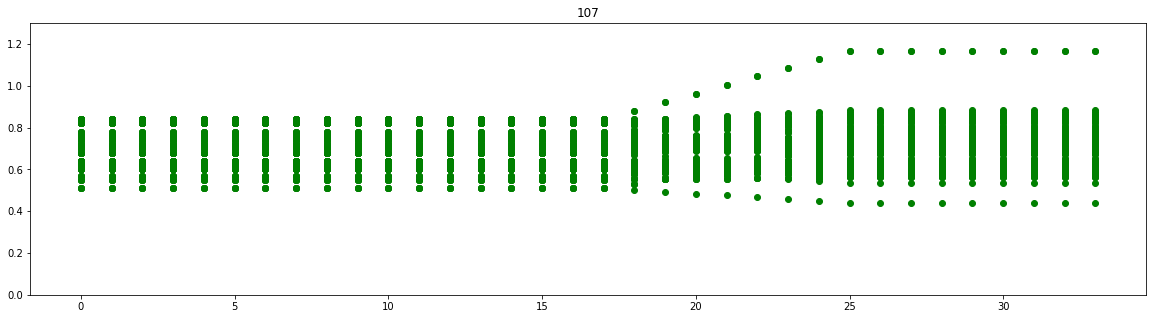

In [8]:
samples = [X for X in range(data['prediction'].shape[0])]

X = [X for X in range(0,5)]

# X = [X for X in range(data['encoder_target'][0:10])]

print(X)

X.append(len(X))

print(X)

files = [1,]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
for sample in samples:
    # data = np.load(ifile)

    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
    
    Y = np.array([])
    Y_= np.array([])
    
    Y = np.concatenate( (Y, np.asarray(data['encoder_target'][sample][...])) )
    Y_= np.concatenate( (Y_, np.asarray(data['encoder_target'][sample][...])) )
    
    # print(Y.shape)
    # fn

    # Y = np.asarray(data['decoder_target'][sample][...]) 
    # Y_ = np.asarray(data['prediction'][sample,...,0]) 
    
    Y = np.concatenate( (Y, np.asarray(data['decoder_target'][sample][...])) ) 
    # Y_ = np.concatenate((Y_, np.asarray(data['prediction'][sample,...,0])) ) 
    
    # print(county, Y)
    # print(Y_)
    X = [X for X in range(len(Y))]
    ax.plot(np.asarray(X), np.asarray(Y), 'o', color='green')
    # ax.plot(np.asarray(X), np.asarray(Y_), '.', color='red')
    ax.set(title=sample)
plt.ylim([0, 1.3])
plt.show()

# for ifile in files:
#     # data = np.load(ifile)
    
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
#     for county in counties:
#         Y = np.asarray(data['decoder_target'][county][0]) 
#         Y_ = np.asarray(data['prediction'][county,0,0]) 
#         # print(county, Y)
#         # print(Y_)
#         ax.plot(np.asarray(county), np.asarray(Y), 'o', color='green')
#         ax.plot(np.asarray(county), np.asarray(Y_), '.', color='red')
#         ax.set(title=ifile)
#     plt.ylim([0, 1.3])
#     plt.show()

In [7]:
fn

NameError: name 'fn' is not defined

In [ ]:
scrop = 'rice'

# MOD_BINS = 128
# FAM_BINS = 64

MOD_BINS = 512
FAM_BINS = 256

print( time.asctime( time.localtime(time.time()) ) )
alidata = pd.read_csv(f'data/ALIM{MOD_BINS}F{FAM_BINS}DATASET_{scrop}.csv')
print( 'DATASET loaded', time.asctime( time.localtime(time.time()) ) )

In [ ]:
display(alidata)

del alidata['Unnamed: 0']
# del alidata['Unnamed: 0.1']
# del alidata['Unnamed: 0.2']
# # del alidata['Unnamed: 0.1.1']
# del alidata['Unnamed: 0.1.1.1']

alidata['county']   = alidata['county'].astype(str)
alidata['year']     = alidata['year'].astype(str)
alidata['time_idx'] = alidata['time_idx'].astype(int)

print(type(alidata['county']), type(alidata['year']), type(alidata['time_idx'].max()))

yield_list = [f'{scrop}_sownarea', f'avg_{scrop}_sownarea', f'med_{scrop}_sownarea', \
              f'{scrop}_yieldval', f'avg_{scrop}_yieldval', f'med_{scrop}_yieldval', \
              f'{scrop}_yield', f'avg_{scrop}_yield', f'med_{scrop}_yield']

cols_to_move = yield_list
alidata = alidata[ [ col for col in alidata.columns if col not in cols_to_move ] + cols_to_move ]

# df_not_str = alidata.select_dtypes(include=float).astype("float32")
# df_str = alidata.select_dtypes(exclude=float)

# alidata = df_not_str.join(df_str)

alidata = alidata[ alidata['month'] < 11 ]

display(alidata)

In [ ]:
# aliv = alidata[ alidata['year'] == '2004']
# alio = alidata[ alidata['year'] == '2003']

# months = alidata['month'].unique()

# for month in months:
#     display(aliv[ aliv['month'] == month ])
#     display(alio[ alio['month'] == month ])
               
# fn

In [ ]:
infer_mask = alidata['year'].isin(['2019', '2020', '2021', '2022'])

data_infer = alidata[infer_mask]

data_infer['rice_sownarea'] = np.nan
data_infer['rice_yieldval'] = np.nan
data_infer['rice_yield']    = np.nan

years = [str(x) for x in range(2003, 2019)]

val_year = str(2004)

years.remove(val_year)

train_mask = alidata['year'].isin(years)
data = alidata[train_mask]

val_mask = alidata['year'].isin([val_year])
data_val = alidata[val_mask]

display(data_infer)

display(data)

display(data_val)

data_inference = pd.concat([data_val, data_infer], axis=0)

display(data_inference)

print(len(data['county'].unique()), len(data['year'].unique()))

# fn


In [ ]:
# max_prediction_length = 4
# max_encoder_length = 20
# training_cutoff = data["time_idx"].max() - max_prediction_length
# min_prediction_idx = 20 #int( training_cutoff )
max_encoder_length = 30  # int(training_cutoff - max_prediction_length)
max_prediction_length = int(data["time_idx"].max() - max_encoder_length + 1)

print( max_encoder_length, type(data["time_idx"][0]), type(max_encoder_length) )
# fn

# print(training_cutoff, data['time_idx'][0])

for county in data['county'].unique():
    for year in data['year'].unique():
        avg_yield = data['avg_rice_yield'].loc[(data['county'] == county) & (data['year'] == year)].mean()
        med_yield = data['med_rice_yield'].loc[(data['county'] == county) & (data['year'] == year)].mean()
        data['rice_yield'].loc[(data['county'] == county) & (data['year'] == year) & (data['time_idx'] < max_encoder_length) ] = ( avg_yield + med_yield ) / 2.0

for county in data['county'].unique():
    avg_yield = data_val['avg_rice_yield'].loc[(data_val['county'] == county) ].mean()
    med_yield = data_val['med_rice_yield'].loc[(data_val['county'] == county) ].mean()
    data_val['rice_yield'].loc[(data_val['county'] == county) & (data_val['time_idx'] < max_encoder_length) ] = ( avg_yield + med_yield ) / 2.0

for county in data_inference['county'].unique():
    for year in data_inference['year'].unique():
        avg_yield = data_inference['avg_rice_yield'].loc[(data_inference['county'] == county) & (data_inference['year'] == year)].mean()
        med_yield = data_inference['med_rice_yield'].loc[(data_inference['county'] == county) & (data_inference['year'] == year)].mean()
        data_inference['rice_yield'].loc[(data_inference['county'] == county) & (data_inference['year'] == year) & (data_inference['time_idx'] < max_encoder_length) ] = ( avg_yield + med_yield ) / 2.0

display(data[ (data['county'] == '0') & (data['year'] == '2003') ])

display(data_val[ (data_val['county'] == '0') ])

display(data_inference[ (data_inference['county'] == '0') ])

display(data_inference[ (data_inference['county'] == '0') & (data_inference['year'] == '2019') ])

# fn

In [ ]:


avg_med = ["avg_rice_yield", "med_rice_yield", "avg_rice_sownarea", "med_rice_sownarea",\
                 "avg_rice_yieldval", "med_rice_yieldval"]

_static_reals = avg_med

_time_varying_known_reals = []
_time_varying_known_reals.extend(avg_med)

# display( data[ [ col for col in _time_varying_known_reals ] ] )

# fn

mod_names = [f'b{iband}b{bins}' for iband in range(9) for bins in range(MOD_BINS)]

famine_list = ['Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg', 'Psurf_f_tavg', 'Qair_f_tavg', 'Qg_tavg', 'Qh_tavg', 'Qle_tavg',\
            'Qs_tavg', 'Qsb_tavg', 'RadT_tavg', 'Rainf_f_tavg', 'SnowCover_inst', 'SnowDepth_inst', 'Snowf_tavg', \
            'SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', \
            'SoilTemp00_10cm_tavg', 'SoilTemp10_40cm_tavg', 'SoilTemp40_100cm_tavg', \
            'SWdown_f_tavg', 'SWE_inst', 'Swnet_tavg', 'Tair_f_tavg', 'Wind_f_tavg']

nbins = ['_' + str(x) for x in range(0, FAM_BINS - 1)]

famine_names = [famine + bb for famine in famine_list for bb in nbins]

_time_varying_unknown_reals = []
_time_varying_unknown_reals.extend(avg_med)
_time_varying_unknown_reals.extend(mod_names)
# _time_varying_unknown_reals.extend(famine_names)

# display( data[ [ col for col in _time_varying_unknown_reals ] ] )

# fn

# display( data[ [ col for col in mod_names ] ] )

# display( data[ [ col for col in famine_names ] ] )

# fn

print( data.sort_values("time_idx").groupby(["county", "year"]).time_idx.diff().dropna() == 1 )

print( time.asctime( time.localtime(time.time()) ) )

training = TimeSeriesDataSet(
    # data[lambda x: x.time_idx <= training_cutoff],
    data,
    time_idx="time_idx",
    target="rice_yield",
    group_ids=["county", "year"],
    # min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length = max_encoder_length,
    # min_prediction_length = 1 , # max_prediction_length // 2,
    max_prediction_length = max_prediction_length,
    # min_prediction_idx = min_prediction_idx,
    # static_categoricals = ["county", "year"],
    # static_reals = _static_reals,
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"years": years},  # group of categorical variables can be treated as one variable
    time_varying_known_reals = _time_varying_known_reals,
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals = _time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(
        groups=["county", "year"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

print( time.asctime( time.localtime(time.time()) ) )

validation = TimeSeriesDataSet(
    data_val,
    time_idx="time_idx",
    target="rice_yield",
    group_ids=["county", "year"],
    # min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length = max_encoder_length,
    # min_prediction_length = 1 , # max_prediction_length // 2,
    max_prediction_length = max_prediction_length,
    # min_prediction_idx = min_prediction_idx,
    # static_categoricals = ["county", "year"],
    # static_reals = _static_reals,
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"years": years},  # group of categorical variables can be treated as one variable
    time_varying_known_reals = _time_varying_known_reals,
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals = _time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(
        groups=["county", "year"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
# validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

print( time.asctime( time.localtime(time.time()) ) )


In [ ]:
print(data['b0b10'].dtypes)
print(data['Evap_tavg_10'].dtypes)

In [ ]:
# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

In [ ]:
print( time.asctime( time.localtime(time.time()) ) )
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
# for x, (y, weight) in iter(val_dataloader):
#     print(type(y), y.size())
    
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
print( type(actuals), actuals.size(), baseline_predictions.size(), actuals[0,:], baseline_predictions[0,:] )
print( torch.where(torch.isnan(actuals)), torch.where(torch.isnan(baseline_predictions)) )
print( (actuals - baseline_predictions).abs().mean().item() )
print( 'Baseline:', time.asctime( time.localtime(time.time()) ) )

# fn

In [ ]:
from pytorch_lightning.callbacks import LearningRateFinder


class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones
        self.gamma = 0.5
        self.optimizer = []
        self.scheduler = []
        # self.optimizer = []
        # self.scheduler = []

    def on_fit_start(self, trainer, pl_module):
        self.optimizer = trainer.optimizers[0]
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, self.milestones, self.gamma)
        # StepLR(optimizer, self.step_size, self.gamma)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.scheduler.get_last_lr()[0]
        self.scheduler.step()
        print('on_fit_start:', self.scheduler.get_last_lr()[0])
        return

    def on_train_epoch_start(self, trainer, pl_module):
        # if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
        # optimizer = trainer.optimizers[0]
        # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, self.milestones, self.gamma)
        # StepLR(optimizer, self.step_size, self.gamma)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.scheduler.get_last_lr()[0]
        self.scheduler.step()
        print('on_train_epoch_start:', self.scheduler.get_last_lr()[0])

In [ ]:
from pytorch_forecasting.metrics import MultiHorizonMetric

class Myloss(MultiHorizonMetric):
    """
    Root mean square error + MAE

    Defined as ``(y_pred - target)**2``
    """

    def __init__(self, reduction="sqrt-mean", **kwargs):
        super().__init__(reduction=reduction, **kwargs)
        
    def loss(self, y_pred, target):
        loss = 0.5 * ( torch.sqrt( torch.pow(self.to_prediction(y_pred) - target, 2) ) + \
                      (self.to_prediction(y_pred) - target).abs() )
        return loss

In [ ]:
from pytorch_lightning.callbacks import GradientAccumulationScheduler

# till 5th epoch, it will accumulate every 8 batches. From 5th epoch
# till 9th epoch it will accumulate every 4 batches and after that no accumulation
# will happen. Note that you need to use zero-indexed epoch keys here
_accumulator = GradientAccumulationScheduler(scheduling={0: 1, 160: 4, 450: 4})

In [ ]:
# dir = '/hy-tmp/chck/ali'
# home_dir = '/content/gdrive/My Drive/AChina' 
_dir = os.path.join(home_dir, 'data')
_checkpoint_callback = ModelCheckpoint(dirpath = _dir + f'{scrop}', every_n_epochs = 50)

_dir = '/tf_logs'
# dir = os.path.join(home_dir, 'data')
_logger = TensorBoardLogger(_dir, name = f'{scrop}-с', comment = f'{scrop}')

_lr_monitor = LearningRateMonitor(logging_interval = 'epoch')

_lr_finder  = FineTuneLearningRateFinder(milestones = [600, 440])

_swa = StochasticWeightAveraging(swa_lrs=1e-2, swa_epoch_start=50, device='gpu')

trainer = Trainer(accelerator='gpu', logger=_logger, log_every_n_steps=1, max_epochs=600,
                  # devices = "0",
                  # fast_dev_run=True, 
                  # precision=16,
                  gradient_clip_val=0.3,
                  callbacks=[_lr_finder, _checkpoint_callback, _lr_monitor, _accumulator])

learning_rate = 0.01

model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    # # lstm_layers=2,
    # hidden_size=16,
    # attention_head_size=4,
    dropout=0.3,
    # hidden_continuous_size=8,
    # output_size=1,  # 7 quantiles by default
    # loss=Myloss(),
    loss=QuantileLoss(),
    # optimizer = 'adam',
    # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    # reduce_on_plateau_patience=4,
    )

In [ ]:
# # find optimal learning rate
# res = trainer.tuner.lr_find(
#     model,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

# fn

In [ ]:
# import pickle

# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

# fn

In [ ]:
print( time.asctime( time.localtime(time.time()) ) )
trainer.fit(
    model,
    train_dataloaders = train_dataloader,
    val_dataloaders   = val_dataloader,
)
print('fit:', time.asctime( time.localtime(time.time()) ) )

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# os.chdir(os.path.join(home_dir, 'data'))
#   best_model_path = trainer.checkpoint_callback.best_model_path
# print(type(best_model_path))
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

print('weights saving', time.asctime( time.localtime(time.time()) ) )
checkpoint = f"{scrop}_{val_year}.ckpt"
trainer.save_checkpoint(checkpoint)
print('weights loading', time.asctime( time.localtime(time.time()) ) )
best_tft = model  # TemporalFusionTransformer.load_from_checkpoint(checkpoint)
print('weights loaded', time.asctime( time.localtime(time.time()) ) )

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
print(type(actuals), actuals.device, actuals.size(), actuals.size()[0])
print(type(predictions), predictions.device, predictions.size())

print(actuals[0,0], predictions[0,0])

# for county in range(actuals.size()[0]):
#     # print(actuals[county,:], predictions[county,:])
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
#     ax.plot(actuals[county, :], color='r')
#     ax.plot(predictions[county, :], color='b')

# plt.show()

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
print(type(raw_predictions), raw_predictions.keys()) 
print(type(x), x.keys()) 
print(type(raw_predictions['prediction']), raw_predictions['prediction'].shape)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
import json

experiment = {}
experiment.update( raw_predictions )
experiment.update( x )

print(experiment.keys())
print(experiment['prediction'].numpy().shape)
print(experiment['encoder_target'].size())
print(experiment['decoder_target'].size())

np.savez(
    f'data/AAA{val_year}EXPERIMENT_quantil.npz',
    prediction = experiment['prediction'].numpy(),
    encoder_target = experiment['encoder_target'].numpy(),
    decoder_target = experiment['decoder_target'].numpy(),
    )  

# with open(f'data/AAA{val_year}EXPERIMENT.csv', "w") as outfile:
#     json.dump(experiment, outfile)

# expert = pd.DataFrame(experiment)

# expert.to_csv(f'data/AAA{val_year}EXPERIMENT.csv')

# display(expert)

In [ ]:
inference = TimeSeriesDataSet(
    data_inference,
    time_idx="time_idx",
    target="rice_yield",
    group_ids=["county", "year"],
    # min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length = max_encoder_length,
    # min_prediction_length = 1 , # max_prediction_length // 2,
    max_prediction_length = max_prediction_length,
    # min_prediction_idx = min_prediction_idx,
    # static_categoricals = ["county", "year"],
    # static_reals = _static_reals,
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"years": years},  # group of categorical variables can be treated as one variable
    time_varying_known_reals = _time_varying_known_reals,
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals = _time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(
        groups=["county", "year"], transformation="softplus"
    ),  # use softplus and normalize by group
    # add_relative_time_idx=True,
    add_target_scales=True,
    # add_encoder_length=True,
)

In [ ]:
inf_dataloader = inference.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

In [ ]:
# print('weights saving', time.asctime( time.localtime(time.time()) ) )
# checkpoint = f"{scrop}_{val_year}.ckpt"
# trainer.save_checkpoint(checkpoint)
print('weights loading', time.asctime( time.localtime(time.time()) ) )
best_tft = TemporalFusionTransformer.load_from_checkpoint(checkpoint)
print('weights loaded', time.asctime( time.localtime(time.time()) ) )

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(inf_dataloader)])
predictions = best_tft.predict(inf_dataloader)

In [ ]:
print(type(actuals), actuals.device, actuals.size(), actuals.size()[0])
print(type(predictions), predictions.device, predictions.size())

print(actuals[0,0], predictions[0,0])

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(inf_dataloader, mode="raw", return_x=True)

In [ ]:
print(type(raw_predictions), raw_predictions.keys()) 
print(type(x), x.keys()) 
print(type(raw_predictions['prediction']), raw_predictions['prediction'].shape)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
import json

experiment = {}
experiment.update( raw_predictions )
experiment.update( x )

print(experiment.keys())
print(experiment['prediction'].numpy().shape)
print(experiment['encoder_target'].size())
print(experiment['decoder_target'].size())

np.savez(
    f'data/AAA{scrop}_{val_year}FULLEXPERIMENT.npz',
    prediction = experiment['prediction'].numpy(),
    encoder_target = experiment['encoder_target'].numpy(),
    decoder_target = experiment['decoder_target'].numpy(),
    )  